# Import

In [1]:
!pip install --upgrade torch torchvision

In [2]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

PyTorch version: 2.1.2+cu121
Torchvision version: 0.16.2+cu121


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import torchvision
import numpy as np
import gc  
from albumentations import (
    Compose, Normalize, Resize,
    RandomResizedCrop, HorizontalFlip,
    RandomBrightnessContrast, ShiftScaleRotate
)
from albumentations.pytorch import ToTensorV2
import cv2
from datetime import datetime
import pytz
from tqdm import tqdm
import timm
import sys


sys.path.append('../tools')
from utils import *

# Config

In [4]:
class Config:
    competition = "sake"
    name = "meigara_classification_baseline_archface"

    debug = False

    training = True
    evaluation = True
    embedding = True

    seed = 8823
    n_fold = 5
    trn_fold = [0,1,2,3,4]

    target_columns = ["meigara_label"]
    size = 512

    model_name = "tf_efficientnet_b0_ns"
    max_epochs = 5
    train_batch_size = 32
    valid_batch_size = 20 # 128
    num_workers = 4
    gradient_accumulation_steps = 1
    clip_grad_norm = 1000

    optimizer = dict(
        optimizer_name="AdamW",
        lr=1e-4,
        weight_decay=1e-2,
        eps=1e-6,
        beta=(0.9, 0.999),
        encoder_lr=1e-4,
        decoder_lr=1e-4,
    )

    scheduler = dict(
        scheduler_name="cosine",
        num_warmup_steps_rate=0,
        num_cycles=0.5,
    )
    batch_scheduler = True

# Check

`./data`配下のディレクトリ構造

In [5]:
tree(path = '../data/', show_files=False)

<data>
　├<input>
　│　├<01_multiclass>
　│　│　├<train>
　│　│　│　├<Hazelnut>
　│　│　│　├<Rotary_beacon_light>
　│　│　│　└<Coffee_beans>
　│　│　└<test>
　│　│　　　├<Rotary_beacon_light_good>
　│　│　　　├<Coffee_beans_abn>
　│　│　　　├<Hazelnut_abn>
　│　│　　　├<Rotary_beacon_light_abn>
　│　│　　　├<Hazelnut_good>
　│　│　　　└<Coffee_good>
　│　├<Hazelnut>
　│　│　├<train>
　│　│　│　├<crack>
　│　│　│　└<good>
　│　│　└<test>
　│　│　　　├<crack>
　│　│　　　└<good>
　│　├<Rotary_beacon_light>
　│　│　├<train>
　│　│　│　└<good>
　│　│　└<test>
　│　│　　　├<nocolor>
　│　│　　　├<yellow>
　│　│　　　├<good>
　│　│　　　└<red>
　│　└<Coffee_beans>
　│　　　├<train>
　│　　　│　├<good>
　│　　　│　└<chocolate>
　│　　　└<test>
　│　　　　　├<good>
　│　　　　　├<candy>
　│　　　　　└<chocolate>
　└<output>


In [6]:
tree(path = '../data/input/Hazelnut/test/', show_files=True)

<test>
　├<crack>
　│　├tn004.jpg
　│　├tn010.jpg
　│　├tn012.jpg
　│　├tn008.jpg
　│　├tn001.jpg
　│　├tn015.jpg
　│　├tn013.jpg
　│　├tn005.jpg
　│　├tn006.jpg
　│　├tn007.jpg
　│　├tn009.jpg
　│　├tn003.jpg
　│　├tn011.jpg
　│　├tn002.jpg
　│　└tn014.jpg
　└<good>
　　　├to005.jpg
　　　├to023.jpg
　　　├to007.jpg
　　　├to009.jpg
　　　├to022.jpg
　　　├to017.jpg
　　　├to001.jpg
　　　├to002.jpg
　　　├to021.jpg
　　　├to006.jpg
　　　├to003.jpg
　　　├to013.jpg
　　　├to016.jpg
　　　├to010.jpg
　　　├to011.jpg
　　　├to004.jpg
　　　├to020.jpg
　　　├to014.jpg
　　　├to018.jpg
　　　├to015.jpg
　　　├to019.jpg
　　　├to008.jpg
　　　├to025.jpg
　　　├to024.jpg
　　　└to012.jpg


# 共通

# 実験1.マルチクラス分類

## 画像データの格納

In [7]:
# 必要なディレクトリ構成に変更

copy_images('../data/input/Hazelnut/train/good/','../data/input/01_multiclass/train/Hazelnut/')
copy_images('../data/input/Rotary_beacon_light/train/good/','../data/input/01_multiclass/train/Rotary_beacon_light/')
copy_images('../data/input/Coffee_beans/train/good/','../data/input/01_multiclass/train/Coffee_beans/')

copy_images('../data/input/Coffee_beans/test/candy/','../data/input/01_multiclass/test/Coffee_beans_abn/')
copy_images('../data/input/Coffee_beans/test/chocolate/','../data/input/01_multiclass/test/Coffee_beans_abn/')
copy_images('../data/input/Coffee_beans/test/good/','../data/input/01_multiclass/test/Coffee_good/')

copy_images('../data/input/Hazelnut/test/crack/','../data/input/01_multiclass/test/Hazelnut_abn/')
copy_images('../data/input/Hazelnut/test/good/','../data/input/01_multiclass/test/Hazelnut_good/')

copy_images('../data/input/Rotary_beacon_light/test/good/','../data/input/01_multiclass/test/Rotary_beacon_light_good/')
copy_images('../data/input/Rotary_beacon_light/test/nocolor/','../data/input/01_multiclass/test/Rotary_beacon_light_abn/')
copy_images('../data/input/Rotary_beacon_light/test/red/','../data/input/01_multiclass/test/Rotary_beacon_light_abn/')
copy_images('../data/input/Rotary_beacon_light/test/yellow/','../data/input/01_multiclass/test/Rotary_beacon_light_abn/')

Files already exist in ../data/input/01_multiclass/train/Hazelnut/. Aborting operation.
Files already exist in ../data/input/01_multiclass/train/Rotary_beacon_light/. Aborting operation.
Files already exist in ../data/input/01_multiclass/train/Coffee_beans/. Aborting operation.
Files already exist in ../data/input/01_multiclass/test/Coffee_beans_abn/. Aborting operation.
Files already exist in ../data/input/01_multiclass/test/Coffee_beans_abn/. Aborting operation.
Files already exist in ../data/input/01_multiclass/test/Coffee_good/. Aborting operation.
Files already exist in ../data/input/01_multiclass/test/Hazelnut_abn/. Aborting operation.
Files already exist in ../data/input/01_multiclass/test/Hazelnut_good/. Aborting operation.
Files already exist in ../data/input/01_multiclass/test/Rotary_beacon_light_good/. Aborting operation.
Files already exist in ../data/input/01_multiclass/test/Rotary_beacon_light_abn/. Aborting operation.
Files already exist in ../data/input/01_multiclass/te

## 学習

### 関数

In [8]:
def get_transforms():
    transforms_dict = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(512),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
        'valid': transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    }
    return transforms_dict

In [9]:
class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m

        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        cos_m = math.cos(self.m)
        sin_m = math.sin(self.m)
        th = math.cos(math.pi - self.m)
        mm = math.sin(math.pi - self.m) * self.m

        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * cos_m - sine * sin_m
        phi = torch.where(cosine > th, phi, cosine - mm)

        # output
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

class CustomModel(nn.Module):
    def __init__(self, config, out_dim, pretrained=False):
        super().__init__()
        self.config = config
        self.model = timm.create_model(self.config.model_name, pretrained=pretrained)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()  # custom head にするため
        self.arcface = ArcFace(in_features=self.n_features, out_features=out_dim)

    def feature(self, images):
        feature = self.model(images)
        return feature

    def forward(self, images, labels=None):
        x = self.feature(images)
        x = self.arcface(x, labels)
        return x

In [10]:
def get_optimizer(optimizer_config, model):
    if optimizer_config["optimizer_name"] == "AdamW":
        optimizer = AdamW(
            model.parameters(),
            lr=optimizer_config["lr"],
            betas=optimizer_config["beta"],
            eps=optimizer_config["eps"],
        )
        return optimizer
    else:
        raise NotImplementedError

def get_scheduler(scheduler_config, optimizer, num_train_steps):
    if scheduler_config["scheduler_name"] == "linear":
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(scheduler_config["num_warmup_steps_rate"] * num_train_steps),
            num_training_steps=num_train_steps,
        )
        return scheduler

    elif scheduler_config["scheduler_name"] == "cosine":
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(scheduler_config["num_warmup_steps_rate"] * num_train_steps),
            num_training_steps=num_train_steps,
            num_cycles=scheduler_config["num_cycles"],
        )
        return scheduler

    elif scheduler_config["scheduler_name"] == "cosine_restarts":
        """
        example:
            first_cycle_steps_ratio = 0.25,
            cycle_mult = 1.0,
            max_lr = 2e-5,
            min_lr = 1e-7,
            warmup_steps=100,
            gamma=0.8)
        """
        scheduler = CosineAnnealingWarmupRestarts(
            optimizer,
            first_cycle_steps=int(num_train_steps * scheduler_config["first_cycle_steps_ratio"]),
            cycle_mult=scheduler_config["cycle_mult"],
            max_lr=scheduler_config["max_lr"],
            min_lr=scheduler_config["min_lr"],
            warmup_steps=scheduler_config["warmup_steps"],
            gamma=scheduler_config["gamma"],
        )
        return scheduler

    else:
        raise NotImplementedError

def train_model(dataloaders, model, criterion, optimizer, num_epochs, file_name):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # フェーズを動的に決定
        phases = dataloaders.keys()

        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0
            
            # tqdmを追加して、ループの進捗を表示
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} epoch {epoch+1}"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct_predictions += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions.double() / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    torch.save(model.state_dict(), f'../models/{file_name}.pth')
    print('Finished Training')


In [11]:
def train_model(dataloaders, model, criterion, optimizer, num_epochs, file_name, device):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        phases = dataloaders.keys()

        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct_predictions = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} epoch {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs,labels)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct_predictions += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = correct_predictions.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    torch.save(model.state_dict(), f'../models/{file_name}.pth')
    print('Finished Training')


### 実行

In [12]:
# Get transforms
transforms_dict = get_transforms()

# Load datasets
train_image_dir = '../data/input/01_multiclass/train/'
train_dataset = torchvision.datasets.ImageFolder(root=train_image_dir, transform=transforms_dict['train'])

# Create dataloaders
batch_size = 8
# train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
train_dataloader = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


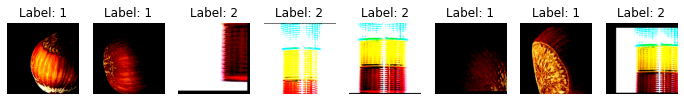

In [13]:
import matplotlib.pyplot as plt

# データローダーから1バッチ分のデータを取得
images, labels = next(iter(train_dataloader['train']))

# バッチの画像とラベルを表示
fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
for ax, img, label in zip(axes, images, labels):
    ax.imshow(img.permute(1, 2, 0))  # CHWをHWCに変更
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.show()

In [14]:
label= [1, 2, 2, 0, 0, 1, 0, 2]

one_hot = torch.zeros(cosine.size(), device='cuda')
one_hot.scatter_(1, label.view(-1, 1).long(), 1)

NameError: name 'cosine' is not defined

In [ ]:
import os
import shutil
import math
out_dim = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set model & optimizer
model = CustomModel(Config, out_dim=out_dim, pretrained=True)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
train_model(train_dataloader, model, criterion, optimizer, num_epochs=5, file_name='angularmodel', device=device)

## 評価

In [ ]:
# 2. 